In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import uncertainties
import numpy as np
import scipy.stats
from cycler import cycler
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import itertools

In [2]:
def eval_Km(value):
    """
        This function is needed since some Km values
        are a list and we need to calculate the geometric mean,
        while others are a single value.
    """
    if pd.isnull(value):
        return np.nan
    Km = eval(value)
    if type(Km) == list:
        return scipy.stats.gmean(Km)
    else:
        return float(Km)

# read the table with enzyme kinetic data and substrates info
kinetics_df = pd.read_csv('data/enzyme_kinetics.csv', index_col=0)
kinetics_df["Km_uM"] = kinetics_df.Km_uM.apply(eval_Km)

# read the table containing the protein abundance data (Schmidt et al.)
protein_df = pd.read_csv('data/protein_abundance_mmol_per_gCDW.csv', index_col=0)
protein_df = protein_df.reset_index().melt(id_vars=["reaction", "gene"], var_name="condition", value_name="protein_abundance_mmol_per_gCDW")

# read the table containing the metabolite abundance data
metabolite_df = pd.read_csv('data/metabolite_concentration_umol_per_gCDW.csv', index_col=(0,1))
metabolite_df = metabolite_df.applymap(lambda x: uncertainties.ufloat_fromstr(x) if type(x)==str else np.nan)
metabolite_df = metabolite_df.reset_index().melt(id_vars=["metabolite", "KEGG_ID"], var_name="condition", value_name="metabolite_concentration_umol_per_gCDW")

# read the flux data (from two sources, Davidi et al. and Gerosa et al.)
davidi_flux_df = pd.read_csv('data/flux_mmol_per_gCDW_s_davidi.csv', index_col=0)
davidi_flux_df = davidi_flux_df.reset_index().melt(id_vars="reaction", var_name="condition", value_name="flux_mmol_per_gCDW_sec")
davidi_flux_df["flux_source"] = "Davidi"
gerosa_flux_df = pd.read_csv('data/flux_mmol_per_gCDW_h_gerosa.csv', index_col=0)
gerosa_flux_df = gerosa_flux_df.applymap(lambda x: uncertainties.ufloat_fromstr(x) if type(x)==str else np.nan)
gerosa_flux_df = gerosa_flux_df.reset_index().melt(id_vars="reaction", var_name="condition", value_name="flux_mmol_per_gCDW_h")
gerosa_flux_df["flux_mmol_per_gCDW_sec"] = gerosa_flux_df.flux_mmol_per_gCDW_h.apply(lambda x: x.nominal_value) / 3600.0
gerosa_flux_df.drop("flux_mmol_per_gCDW_h", axis=1, inplace=True)
gerosa_flux_df["flux_source"] = "Gerosa"
flux_df = pd.concat([davidi_flux_df, gerosa_flux_df])

In [3]:
# join the kcat upper bound with the flux data
# calculate the flux upper bound based on abundance and kcat
# the resulting units are mmol_per_gCDW x 1_per_sec = mmol_per_gCDW_sec

kcat_ub = protein_df.join(kinetics_df.drop("gene", axis="columns"), on="reaction")
kcat_ub["kcat_x_adunbance_mmol_per_gCDW_sec"] = kcat_ub.kcat_1_per_sec * kcat_ub.protein_abundance_mmol_per_gCDW
joined_df = pd.merge(kcat_ub, flux_df, on=["reaction", "condition"], how="left")
joined_df["kapp_1_per_sec"] = joined_df.flux_mmol_per_gCDW_sec / joined_df.protein_abundance_mmol_per_gCDW
joined_df.rename(columns={"Km_metabolite": "KEGG_ID"}, inplace=True)

In [4]:
# calculate the saturation level of the non-cycling substrate
joined_df = pd.merge(joined_df, metabolite_df[["KEGG_ID", "metabolite", "condition", "metabolite_concentration_umol_per_gCDW"]], on=["KEGG_ID", "condition"], how="left")

CELL_DENSITY = 1.1e3 # gr/L
CELL_DRY_FRACTION = 0.3 # gCDW/gr
CELL_DRY_DENSITY = CELL_DRY_FRACTION * CELL_DENSITY # (gr/L) * (gCDW/gr) = gCDW/L

joined_df["Km_umol_per_gCDW"] = joined_df.Km_uM / CELL_DRY_DENSITY  # (μmol/L) / (gCDW/L) = μmol/gCDW

# we need to convert uM into mmol/gCDW for the Km values first
joined_df["saturation"] = joined_df.metabolite_concentration_umol_per_gCDW / (joined_df.metabolite_concentration_umol_per_gCDW + joined_df.Km_umol_per_gCDW)

In [5]:
# Add the data about the total concentration of the cycling (cofactor) pools
cycling_pools = joined_df[["cycling_pool"]].drop_duplicates()
cycling_pools["metabolites"] = cycling_pools.cycling_pool.str.findall("[^\s^+]+")
cycling_pools = cycling_pools.explode("metabolites").set_index("metabolites")

cycling_pool_df = metabolite_df.join(cycling_pools, on="metabolite", how="right").groupby(["condition", "cycling_pool"]).metabolite_concentration_umol_per_gCDW.sum().reset_index()
cycling_pool_df.rename(columns={"metabolite_concentration_umol_per_gCDW": "cofactor_concentration_umol_per_gCDW"}, inplace=True)
joined_df = pd.merge(joined_df, cycling_pool_df, on=["condition", "cycling_pool"])

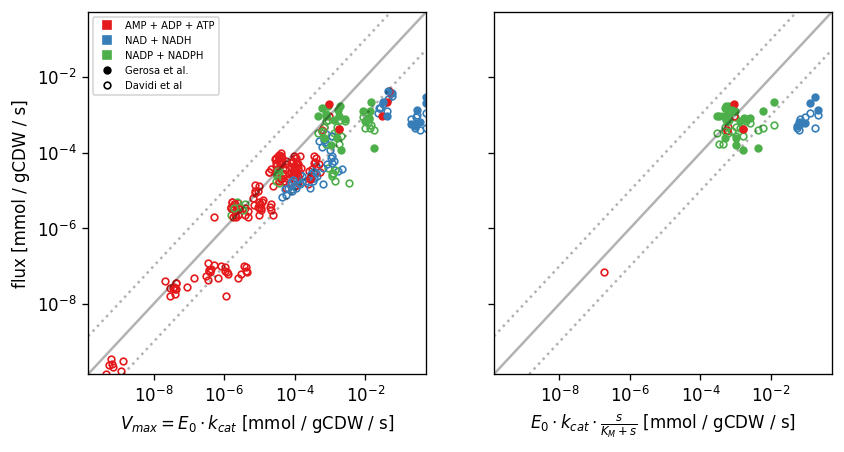

In [6]:
fig3, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=120, sharex=True, sharey=True)

cycling_pools = sorted(joined_df.cycling_pool.unique())
cycling_pool2color = dict(zip(cycling_pools, sns.color_palette("Set1")))
reaction2cycling_pool = kinetics_df.cycling_pool
reaction2color = {r:cycling_pool2color[reaction2cycling_pool[r]] for r in kinetics_df.index}

_df = joined_df[joined_df.flux_mmol_per_gCDW_sec > 0]
_df.insert(0, "x", _df.kcat_x_adunbance_mmol_per_gCDW_sec)
_df.insert(1, "y", _df.flux_mmol_per_gCDW_sec)


ax = axs[0]
for source, group_df in _df.groupby("flux_source"):
    for row in group_df.itertuples():
        color = reaction2color[row.reaction]
        if source == "Gerosa":
            args = {"alpha": 1, "marker": "o", "markerfacecolor": color, "markeredgecolor": color, "markersize": 4, "zorder": 2}
        else:
            args = {"alpha": 1, "marker": "o", "markerfacecolor": "none", "markeredgecolor": color, "markersize": 4, "zorder": 1}
        ax.plot(row.x, row.y, **args)

vmin = min(_df.x.min(), _df.y.min())
vmax = max(_df.x.max(), _df.y.max())
ax.plot([vmin, vmax], [vmin, vmax], "k-", alpha=0.3, label="upper bound")
ax.plot([vmin, vmax/10], [vmin*10, vmax], "k:", alpha=0.3, label="x10 upper bound")
ax.plot([vmin*10, vmax], [vmin, vmax/10], "k:", alpha=0.3, label="x0.1 upper bound")
ax.set_xlim(vmin/2, vmax*2)
ax.set_ylim(vmin/2, vmax*2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$V_{max} = E_0 \cdot k_{cat}$ [mmol / gCDW / s]")
ax.set_ylabel("flux [mmol / gCDW / s]")

legend_elements = [
    Line2D([0], [0], color=cycling_pool2color[c], marker="s", linewidth=0, markersize=5) for c in cycling_pools
] + [
    Line2D([0], [0], markeredgecolor="k", marker="o", markerfacecolor="k", linewidth=0, markersize=4),
    Line2D([0], [0], markeredgecolor="k", marker="o", markerfacecolor="none", linewidth=0, markersize=4),
]
legend_labels = cycling_pools + ["Gerosa et al.", "Davidi et al"]
ax.legend(legend_elements, legend_labels, fontsize=6)


ax = axs[1]
saturation_df = joined_df[(~pd.isnull(joined_df.Km_uM)) & ~(pd.isnull(joined_df.metabolite_concentration_umol_per_gCDW))]

_df = joined_df[(joined_df.flux_mmol_per_gCDW_sec > 0) & (~pd.isnull(joined_df.saturation))]
_df.insert(0, "x", _df.saturation.apply(lambda x: x.nominal_value) * _df.kcat_x_adunbance_mmol_per_gCDW_sec)
_df.insert(1, "y", _df.flux_mmol_per_gCDW_sec)

for source, group_df in _df.groupby("flux_source"):
    for row in group_df.itertuples():
        color = reaction2color[row.reaction]
        if source == "Gerosa":
            args = {"alpha": 1, "marker": "o", "markerfacecolor": color, "markeredgecolor": color, "markersize": 4, "zorder": 2}
        else:
            args = {"alpha": 1, "marker": "o", "markerfacecolor": "none", "markeredgecolor": color, "markersize": 4, "zorder": 1}
        ax.plot(row.x, row.y, **args)

ax.set_xlabel(r"$E_0 \cdot k_{cat} \cdot \frac{s}{K_M + s}$ [mmol / gCDW / s]")
ax.plot([vmin, vmax], [vmin, vmax], "k-", alpha=0.3, label="upper bound")
ax.plot([vmin, vmax/10], [vmin*10, vmax], "k:", alpha=0.3, label="x10 upper bound")
ax.plot([vmin*10, vmax], [vmin, vmax/10], "k:", alpha=0.3, label="x0.1 upper bound")
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.set_xscale("log")
ax.set_yscale("log")

fig3.savefig("res/flux_vs_vmax.pdf")

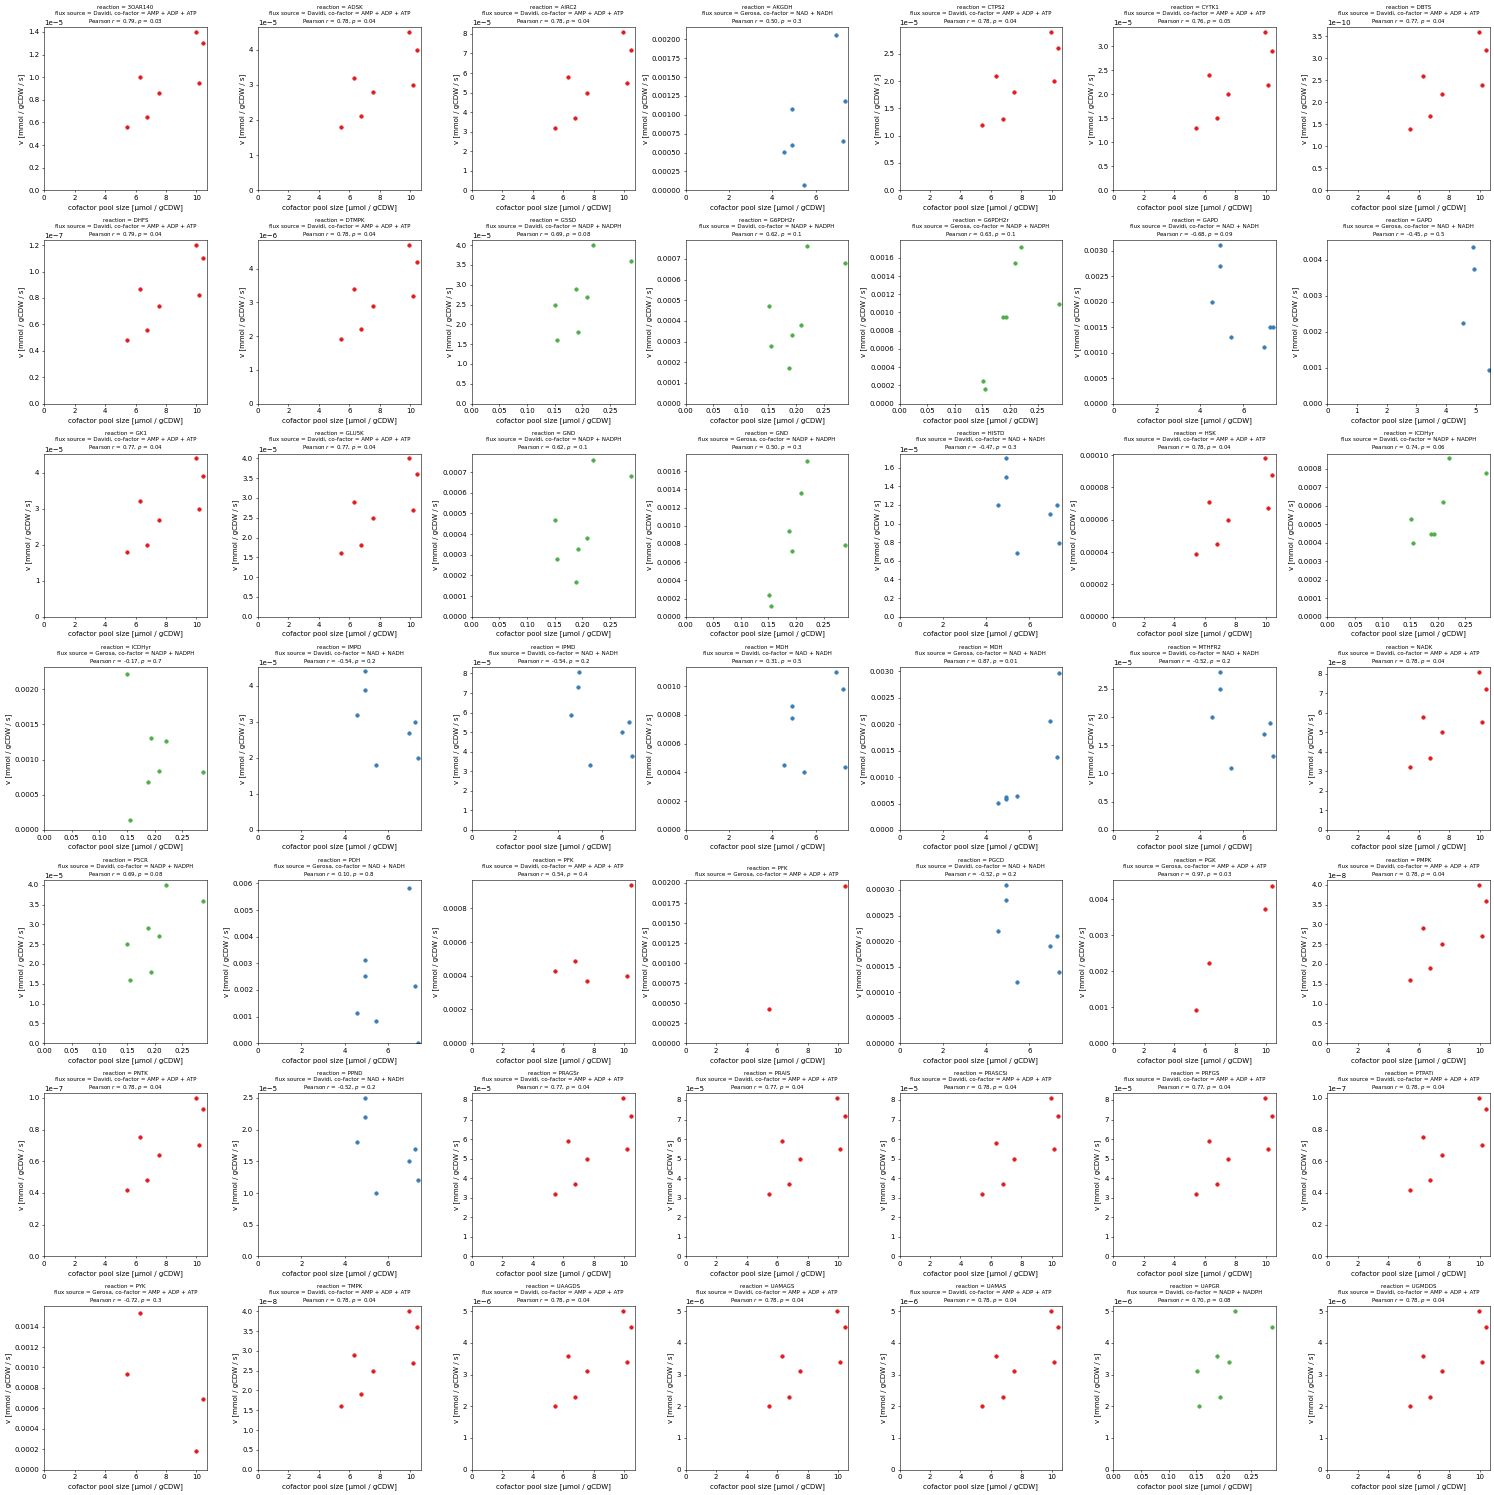

In [8]:
correlation_data = []

fig3, axs = plt.subplots(7, 7, figsize=(30, 30), dpi=50)

for ax, ((reaction, source), group_df) in zip(axs.flat, joined_df[joined_df.flux_mmol_per_gCDW_sec > 0].groupby(["reaction", "flux_source"])):

    for row in group_df.itertuples():
        marker = "o"
        color = reaction2color[row.reaction]
        ax.plot(
            row.cofactor_concentration_umol_per_gCDW.nominal_value,
            row.flux_mmol_per_gCDW_sec,
            marker=marker,
            markersize=5,
            color=color
        )

    x = group_df.cofactor_concentration_umol_per_gCDW.apply(lambda x: x.nominal_value)
    y = group_df.flux_mmol_per_gCDW_sec

    title = f"reaction = {reaction}\nflux source = {source}, co-factor = {group_df.cycling_pool.iat[0]}"
    if group_df.shape[0] > 3:
        pearson_result = scipy.stats.pearsonr(x, y)
        title += f"\nPearson $r$ = {pearson_result.statistic:.2f}, $p$ = {pearson_result.pvalue:.1g}"
        correlation_data.append((reaction, source, group_df.shape[0], pearson_result.statistic, pearson_result.pvalue))
    else:
        correlation_data.append((reaction, source, group_df.shape[0], np.nan, np.nan))
    ax.set_title(title, fontsize=8)
    ax.set_xlabel("cofactor pool size [μmol / gCDW]")
    ax.set_xlim([0, None])
    ax.set_ylabel("v [mmol / gCDW / s]")
    ax.set_ylim([0, None])
fig3.tight_layout()
fig3.savefig("res/correlations.pdf")

In [9]:
correlation_df = pd.DataFrame(correlation_data, columns=["reaction", "flux_source", "number_of_conditions", "pearson_r", "pvalue"])
correlation_df = correlation_df.sort_values("pvalue")
# make a table for the SI with all the correlation data
with open(f"res/correlation.tex", "wt") as fp:
    fp.write(correlation_df.style.to_latex())

display(correlation_df)

,reaction,flux_source,number_of_conditions,pearson_r,pvalue
25,MDH,Gerosa,7,0.874310,0.010042
33,PGK,Gerosa,4,0.973547,0.026453
0,3OAR140,Davidi,7,0.794377,0.032850
7,DHFS,Davidi,7,0.787719,0.035438
46,UAMAS,Davidi,7,0.783767,0.037025
45,UAMAGS,Davidi,7,0.783767,0.037025
44,UAAGDS,Davidi,7,0.783767,0.037025
48,UGMDDS,Davidi,7,0.783767,0.037025
2,AIRC2,Davidi,7,0.783523,0.037125
39,PRASCSi,Davidi,7,0.783523,0.037125
